Hold‑out MAE: 2.92


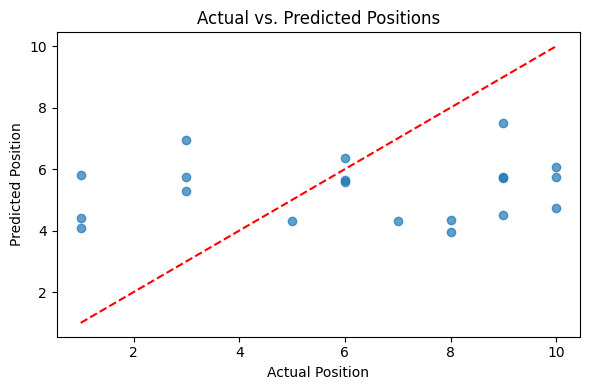

Saved 'ranker_model.joblib' and 'scaler.joblib'.
Dummy MAE: 3.62

Dummy Drivers Predicted Ranking:


,driver_id,predicted_position
2,DR3,5
0,DR1,6
3,DR4,7
1,DR2,9


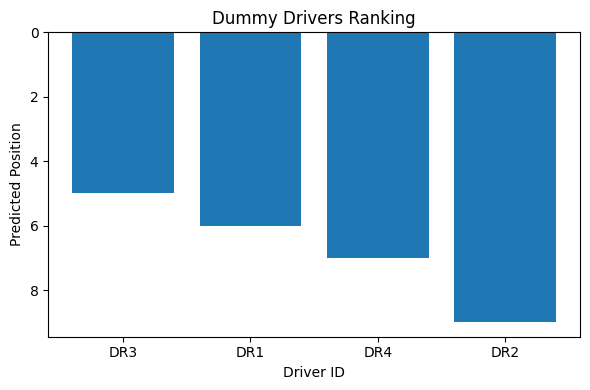

In [7]:
# Paste this into a single Jupyter Notebook cell and run:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from IPython.display import display

# --- 1) Load dataset ---
df = pd.read_csv('season_data.csv')

# --- 2) Feature engineering ---
X = df[['points', 'best_lap_time', 'total_wins']].copy()
X['inv_lap_time'] = -X.pop('best_lap_time')
y = df['finishing_position']

# --- 3) Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 4) Scale features ---
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- 5) Train RandomForest model ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# --- 6) Evaluate on hold-out set ---
y_pred = model.predict(X_test_scaled)
mae_hold = mean_absolute_error(y_test, y_pred)
print(f"Hold‑out MAE: {mae_hold:.2f}")

# --- 7) Plot actual vs. predicted ---
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.7)
minv, maxv = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([minv, maxv], [minv, maxv], 'r--')
plt.xlabel('Actual Position')
plt.ylabel('Predicted Position')
plt.title('Actual vs. Predicted Positions')
plt.tight_layout()
plt.show()

# --- 8) Save artifacts ---
joblib.dump(model, 'ranker_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
print("Saved 'ranker_model.joblib' and 'scaler.joblib'.")

# --- 9) Dummy data test ---
dummy = pd.DataFrame([
    {'driver_id': 'DR1', 'points': 1200, 'best_lap_time': 141.0, 'total_wins': 2, 'finishing_position': 3},
    {'driver_id': 'DR2', 'points': 5000, 'best_lap_time': 139.5, 'total_wins': 4, 'finishing_position': 1},
    {'driver_id': 'DR3', 'points':  900, 'best_lap_time': 145.2, 'total_wins': 0, 'finishing_position': 5},
    {'driver_id': 'DR4', 'points': 1300, 'best_lap_time': 140.2, 'total_wins': 1},  # no actual
])

# Preprocess dummy features
X_d = dummy[['points', 'best_lap_time', 'total_wins']].copy()
X_d['inv_lap_time'] = -X_d.pop('best_lap_time')

# Predict
X_d_scaled = scaler.transform(X_d)
preds_d = model.predict(X_d_scaled)
dummy['predicted_position'] = np.round(preds_d).astype(int)

# Compute MAE only where actual provided
mask = dummy['finishing_position'].notna()
if mask.any():
    mae_dummy = mean_absolute_error(dummy.loc[mask, 'finishing_position'], preds_d[mask])
    print(f"Dummy MAE: {mae_dummy:.2f}")

# Display ranked dummy drivers
ranked_dummy = dummy.sort_values('predicted_position')
print("\nDummy Drivers Predicted Ranking:")
display(ranked_dummy[['driver_id', 'predicted_position']])

# Plot dummy ranking
plt.figure(figsize=(6,4))
plt.bar(ranked_dummy['driver_id'], ranked_dummy['predicted_position'])
plt.gca().invert_yaxis()
plt.xlabel('Driver ID')
plt.ylabel('Predicted Position')
plt.title('Dummy Drivers Ranking')
plt.tight_layout()
plt.show()
